In [1]:
from autoencoder.data.tdms_to_npy_scaling import patch_matrix
a = patch_matrix(1500, save=True)

[nptdms.reader WARNING] Last segment of file has less data than expected, will attempt to read to the end of the file
[nptdms.reader WARNING] Last segment of file has less data than expected, will attempt to read to the end of the file
[nptdms.reader WARNING] Last segment of file has less data than expected, will attempt to read to the end of the file


ws_increment missing of autoencoder/data/tdms_files/P018_S01_D2023-10-04_G25.tdms in group R002 skipping the group


In [ ]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Generate ECG data with different configurations
fetal_clean = nk.ecg_simulate(duration=10, noise=0, heart_rate=120, sampling_rate=1000)
maternal_clean = nk.ecg_simulate(duration=10, noise=0, heart_rate=60, sampling_rate=1000)

# Introduce noise to the fetal ECG signals
fetal_noisy_1 = 0.01 * nk.ecg_simulate(duration=10, noise=0, heart_rate=120, sampling_rate=1000)
fetal_noisy_2 = 0.1 * nk.ecg_simulate(duration=10, noise=10, heart_rate=120, sampling_rate=1000)
fetal_noisy_3 = 0.1 * nk.ecg_simulate(duration=10, noise=15, heart_rate=120, sampling_rate=1000)

# Shift the maternal ECG to simulate fetal ECG at different delays
maternal_shifted_1 = np.roll(maternal_clean, 300)
maternal_shifted_2 = np.roll(maternal_clean, 600)

# Combine fetal and maternal ECG signals without noise
ecg_sum_no_noise_1 = fetal_clean + maternal_shifted_1
ecg_sum_no_noise_2 = fetal_clean + maternal_shifted_2

# Combine noisy fetal ECG signals with maternal ECG
ecg_sum_noise_1 = fetal_noisy_1 + maternal_shifted_1
ecg_sum_noise_2 = fetal_noisy_2 + maternal_shifted_1
ecg_sum_noise_3 = fetal_noisy_3 + maternal_shifted_1
ecg_sum_noise_4 = fetal_noisy_1 + maternal_shifted_2
ecg_sum_noise_5 = fetal_noisy_2 + maternal_shifted_2
ecg_sum_noise_6 = fetal_noisy_3 + maternal_shifted_2

# Create a DataFrame for visualization
ecg_df = pd.DataFrame(
    {
        "fetal_clean": fetal_clean,
        "maternal_clean": maternal_clean,
        "maternal_shifted_1": maternal_shifted_1,
        "maternal_shifted_2": maternal_shifted_2,
        "fetal_noisy_1": fetal_noisy_1,
        "fetal_noisy_2": fetal_noisy_2,
        "fetal_noisy_3": fetal_noisy_3,
        "ecg_sum_no_noise_1": ecg_sum_no_noise_1,
        "ecg_sum_no_noise_2": ecg_sum_no_noise_2,
        "ecg_sum_noise_1": ecg_sum_noise_1,
        "ecg_sum_noise_2": ecg_sum_noise_2,
        "ecg_sum_noise_3": ecg_sum_noise_3,
        "ecg_sum_noise_4": ecg_sum_noise_4,
        "ecg_sum_noise_5": ecg_sum_noise_5,
        "ecg_sum_noise_6": ecg_sum_noise_6
    })

# Calculate and print the kurtosis of each column in ecg_df
kurtosis_values = ecg_df.apply(stats.kurtosis)
print("Kurtosis values:")
print(kurtosis_values)

# Visualize the ECG signals with a larger figure
plt.figure(figsize=(15, 20))
nk.signal_plot(ecg_df, subplots=True)
plt.show()


In [ ]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score

# Generate ECG data with different configurations
fetal_clean = nk.ecg_simulate(duration=6, noise=0, heart_rate=120, sampling_rate=1000)
maternal_clean = nk.ecg_simulate(duration=6, noise=0, heart_rate=60, sampling_rate=1000)

# Create a DataFrame for visualization
ecg_df = pd.DataFrame(
    {
        "fetal_clean": fetal_clean,
        "maternal_clean": maternal_clean,
    })


# Correlation Coefficient
correlation = np.corrcoef(ecg_df['fetal_clean'], ecg_df['maternal_clean'])[0, 1]
print(f'Correlation coefficient between fetal clean and maternal clean ECG: {correlation}')

# Discretize the data into bins
bins = 10000
fetal_clean_binned = pd.cut(ecg_df['fetal_clean'], bins, labels=False)
maternal_clean_binned = pd.cut(ecg_df['maternal_clean'], bins, labels=False)

# Calculate Mutual Information on binned data
mutual_info = mutual_info_score(fetal_clean_binned, maternal_clean_binned)
print(f'Mutual information between fetal clean and maternal clean ECG: {mutual_info}')




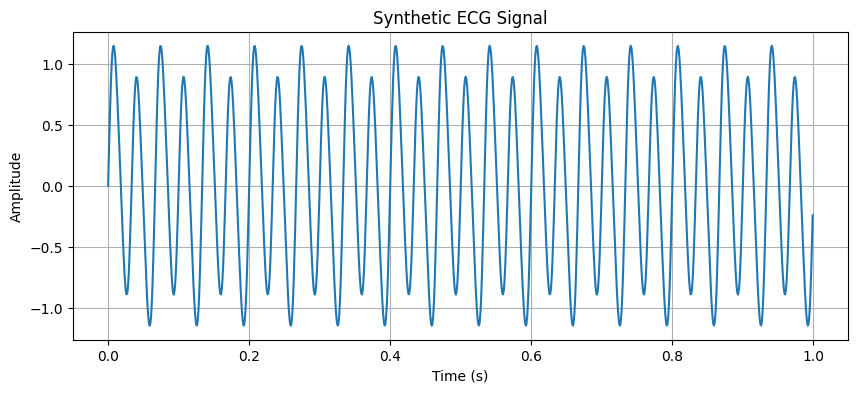

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def generate_ecg_signal(fs, duration, heart_rate, noise_level=0.1):
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    
    # Generate individual components of the ECG signal
    p_wave = np.sin(2 * np.pi * 1.0 * heart_rate * t)
    qrs_complex = np.sin(2 * np.pi * 0.5 * heart_rate * t)
    t_wave = np.sin(2 * np.pi * 0.25 * heart_rate * t)
    
    # Combine components to create ECG signal
    ecg_signal = 0.1 * p_wave + qrs_complex + 0.2 * t_wave
    
    return t, ecg_signal

# Parameters
fs = 1000  # Sampling frequency (Hz)
duration = 1  # Duration of the ECG signal (seconds)
heart_rate = 60  # Heart rate (beats per minute)

# Generate ECG signal
t, ecg_signal = generate_ecg_signal(fs, duration, heart_rate)

# Plot the ECG signal
plt.figure(figsize=(10, 4))
plt.plot(t, ecg_signal)
plt.title("Synthetic ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()
